# **PRE-PROCESAMIENTO, TRANSFORMACIÓN Y LIMPIEZA DE DATOS: CASO WALMART**

## Importar librerías:

In [1]:
import pandas as pd
import gc
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Introducción:

M5 se trata de una serie temporal de cinco años sobre los datos de ventas unitarias diarias de diez tiendas Walmart, localizadas en tres estados de los Estados Unidos: California, Texas y Wisconsin. La información contenida describe el comportamiento de 3.049 productos, clasificados en siete departamentos diferentes que, a su vez, se encasillan en tres categorías: hobbies, foods y household.

La base de datos inicial consta de tres tablas distintas, donde una de ellas comprende el histórico de las ventas, otra contiene la información sobre los precios de venta y, finalmente, se incluye una tabla de calendario.
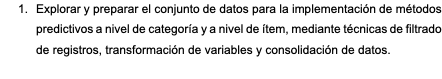
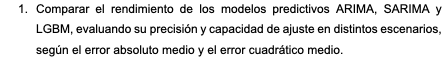
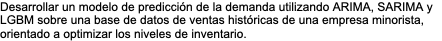
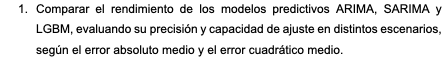
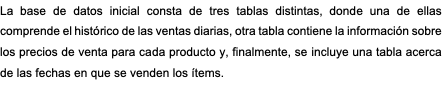
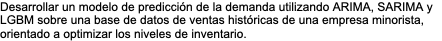
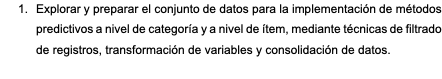
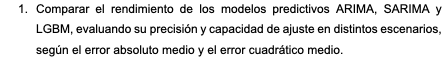
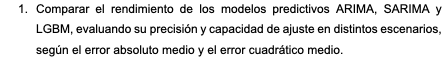
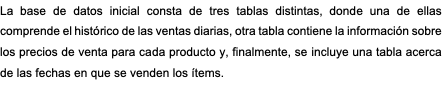
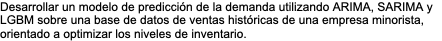
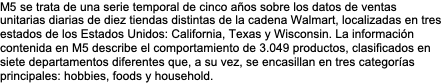
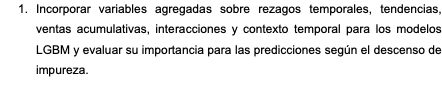
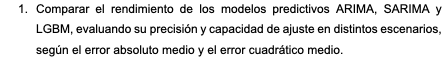
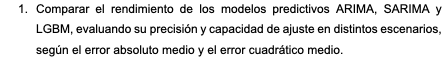
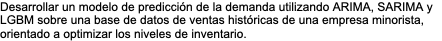
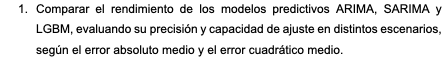
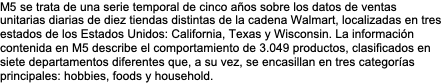
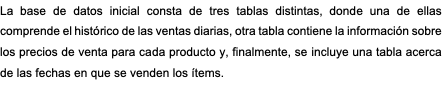
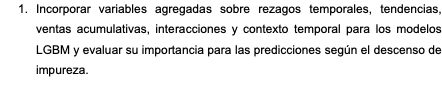
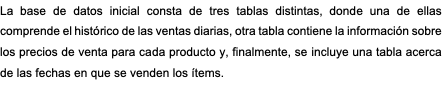
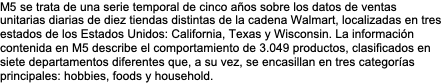
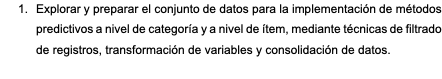
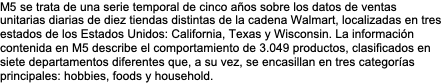
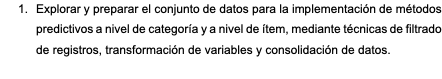
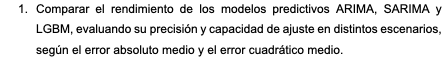
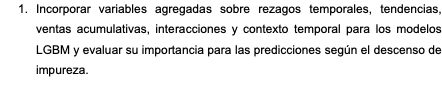
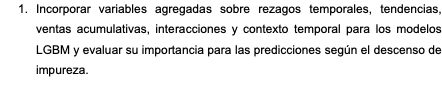

## Metodología:
1. Cargar y revisar los conjuntos de datos.
2. Pre-procesamiento y transformación de los datos.
3. Limpieza de datos.
4. Crear datasets filtrados a distintos niveles de agregación.

## **1. Cargar y revisar los conjuntos de datos**

In [2]:
# Cargar los conjuntos de datos
sales_data = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
calendar_data = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
prices_data = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')

In [3]:
#Visualizar la información del conjunto sales
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [4]:
#Visualizar la información del conjunto calendar
calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [5]:
#Visualizar la información del conjunto prices
prices_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


A simple vista, se puede destacar lo siguiente:
- Conjunto de ventas: Incluye 30.490 filas y 1.947 columnas, donde cada fila representa un producto y las columnas de ventas diarias (d_1 a d_1941). Cabe resaltar que será necesario pivotar las columnas diarias (d_1, d_2, ...) para obtener un formato de serie temporal.
- Conjunto de calendario: Contiene 1,969 filas con información sobre fechas, días festivos, estacionalidad y variables promocionales por estado (California, Texas y Wisconsin).
- Conjunto de precios: Cuenta con 6.8 millones de registros, relacionando productos y precios por tienda a lo largo del tiempo.

## **2. Pre-procesamiento y transformación de datos**

Antes de avanzar, es importante resaltar que el presente conjunto de datos se presta para realizar análisis a distinta granularidad; por ejemplo, se podría realizar un análisis considerando el total de ventas de todas las tiendas a lo largo de los cinco años, o bien, se podría realizar un análisis de un solo ítem de una tienda en específico. Todo depende de los propósitos del estudio y los requerimientos del negocio.

Para este presente proyecto, se decidió filtrar los datos para enfocarnos en una única tienda del Estado de California y limitarnos únicamente a los últimos 3 años. Esto con el objetivo de orientarnos hacia un enfoque más específico y contar con un conjunto de datos más manejable. Con ello, se optó por segmentar o filtrar los datos para abordar el análisis a nivel de categoría, específicamente la de **alimentos**. Además, se decidió realizar un segundo ejercicio, centrándonos específicamente en el ítem **foods_2_347**.

Con esto en mente, se partió por eliminar algunas columnas innecesarias para los propósitos del presente estudio, lo cual también ayuda a ahorrar memoría:

In [6]:
# Eliminar ciertas columnas innecesarias
calendar_data = calendar_data.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI'])

Seguido, se procedió a transformar las columnas "d..." del conjunto de ventas para pasar de un formato ancho a un formato largo:

In [7]:
# Transformar las columnas 'd_1', 'd_2', ..., 'd_1913' de la tabla de ventas en una sola columna 'day'
sales_data_melted = pd.melt(sales_data, 
                            id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                            var_name='d', 
                            value_name='sales')

Después, se unieron los conjuntos de datos de ventas y calendario:

In [8]:
# Unión izquierda de los archivos "sales" y "calendar" a través de la veriable en común "d" 
merged_data = pd.merge(sales_data_melted, calendar_data, on='d', how='left')

In [9]:
# Eliminar variables que ya no se necesitan
del sales_data
del sales_data_melted
del calendar_data

# Liberar memoria
gc.collect()

0

Se incorporó el conjunto de precios para tener un solo conjunto de datos final:

In [10]:
# Unión izquierda del archivo "prices" considerando las varaibles comunes "store_id" ; "item_id" y "wm_yr_wk".
final_data = pd.merge(merged_data, prices_data, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])

In [11]:
# Eliminar variables que ya no se necesitan
del merged_data
del prices_data

# Liberar memoria
gc.collect()

0

Procederemos a realizar ciertos filtros para tener un conjunto más manejable.

Partimos por filtrar una sola tienda Walmart: "CA_1"

In [12]:
#Filtrar el conjunto de datos para quedarnos únicamente con la tienda "CA_1"
df_filtered = final_data[final_data['store_id'] == 'CA_1']

In [13]:
# Eliminar variables que ya no se necesitan
del final_data

# Liberar memoria
gc.collect()

0

También filtramos únicamente los últimos 3 años:

In [14]:
df_filtered["date"] = pd.to_datetime(df_filtered["date"])

In [15]:
# Definir el rango de tiempo para los últimos 3 años
end_date = df_filtered['date'].max()  # Fecha máxima en el dataset
start_date = end_date - pd.DateOffset(years=3)  # Fecha 3 años antes de la fecha máxima

# Filtrar el dataset para incluir solo los registros de los últimos 3 años
df_last_3_years = df_filtered[df_filtered['date'] >= start_date]

In [16]:
# Eliminar variables que ya no se necesitan
del df_filtered

# Liberar memoria
gc.collect()

0

Eliminamos otras columnas innecesarias:

In [17]:
# Eliminar las columnas innecesarias
columns_to_drop = ['id', 'd', 'wm_yr_wk', 'weekday', 'store_id', 'state_id', 'wday', 'month', 'year']
df_last_3_years = df_last_3_years.drop(columns=columns_to_drop)

In [18]:
# Eliminar variables que ya no se necesitan
del columns_to_drop
del end_date
del start_date

# Liberar memoria
gc.collect()

0

In [19]:
df_last_3_years.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3344753 entries, 25733560 to 59153648
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   item_id     object        
 1   dept_id     object        
 2   cat_id      object        
 3   sales       int64         
 4   date        datetime64[ns]
 5   snap_CA     int64         
 6   sell_price  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 204.1+ MB


Podemos evidenciar, que el dataset final cuenta con 7 variables o columnas y un total de 3.344.753 filas.

Exportamos el conjunto de datos final:

In [20]:
# Exportar el dataset final
df_last_3_years.to_csv('df_last_3_years.csv', index=False)

Con el dataset listo, procedemos a cargarlo:

In [21]:
#Cargar el dataset
df = pd.read_csv('/kaggle/input/df-last-3-years-final/df_last_3_years.csv')

In [22]:
# Eliminar variables que ya no se necesitan
del df_last_3_years

# Liberar memoria
gc.collect()

0

## **3. Limpieza de datos**

Empezaremos por explorar y manejar los valores faltantes:

In [23]:
# Explorar los valores faltantes
missing_data = df.isnull().sum().sort_values(ascending=False)

print("Valores faltantes en cada columna:")
print(missing_data)

Valores faltantes en cada columna:
sell_price    185136
item_id            0
dept_id            0
cat_id             0
sales              0
date               0
snap_CA            0
dtype: int64


Como podemos observar, únicamente tenemos valores nulos para la variable de sell_price. Se imputará los datos nulos empleando la mediana del precio según el producto en cuestión, garantizando que los valores sean reemplazados con un estimado apropiado.
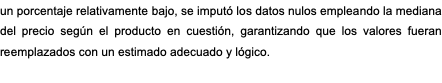
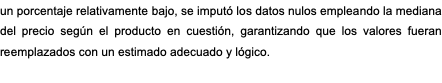
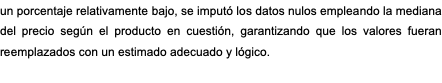
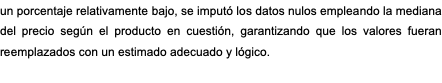

In [24]:
# Imputar los valores faltantes de sell_price con la mediana por item_id
df['sell_price'] = df.groupby('item_id')['sell_price'].transform(lambda x: x.fillna(x.median()))

In [25]:
# Verificar si quedan valores faltantes en sell_price
df['sell_price'].isnull().sum()

0

Con los valores nulos imputados, procederemos a revisar si todas las variables tienen el tipo de dato adecuado:

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344753 entries, 0 to 3344752
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   item_id     object 
 1   dept_id     object 
 2   cat_id      object 
 3   sales       int64  
 4   date        object 
 5   snap_CA     int64  
 6   sell_price  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 178.6+ MB


Vamos a convertir la variable "date" a tipo datetime:

In [27]:
# Convertir la columna 'date' a tipo datetime.
df['date'] = pd.to_datetime(df['date'])

Seguido, vamos a verificar si existen duplicados:

In [28]:
# Verificar si hay filas duplicadas en todo el dataset
duplicated_rows = df.duplicated()

# Contar el número de filas duplicadas
num_duplicated_rows = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicated_rows}")

# Mostrar las filas duplicadas si existen
df_duplicated = df[df.duplicated()]
print(df_duplicated)

Número de filas duplicadas: 0
Empty DataFrame
Columns: [item_id, dept_id, cat_id, sales, date, snap_CA, sell_price]
Index: []


## **4. Crear datsets filtrados a distintos niveles de agregación.**

Vamos a realizar análisis a dos niveles de agregación distintos: por categoría, específicamente la categoría de alimentos; y por ítem, específicamente el ítem foods_2_347.

In [29]:
# Filtrar datos por categoría "FOODS" para análisis a nivel de categoría.
df_foods = df[df['cat_id'] == 'FOODS'].copy()

# Filtrar datos por item_id "FOODS_2_347" para análisis a nivel de ítem o producto.
df_foods_2_347 = df[df['item_id'] == 'FOODS_2_347'].copy()

Ahora, el objetivo es realizar agregaciones al conjunto de datos para obtener un dataset final donde cada fila represente un día de ventas, en este caso para la categoría de alimentos en general.

In [30]:
# Realizar las agregaciones relevantes para la categoría "FOODS"
df_foods_agg = df_foods.groupby('date').agg({
    'sales': 'sum',  # Sumar ventas totales para cada fecha
    'sell_price': 'mean',  # Promedio de precios de venta
    'snap_CA': 'max',  # Máximo valor de snap_CA por semana (si hubo descuento)
}).reset_index()

# Renombrar la columna de ventas a 'sales_total'
df_foods_agg.rename(columns={'sales': 'sales_total'}, inplace=True)

In [31]:
df_foods_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1097 non-null   datetime64[ns]
 1   sales_total  1097 non-null   int64         
 2   sell_price   1097 non-null   float64       
 3   snap_CA      1097 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 34.4 KB


In [32]:
df_foods_agg.head(3)

,date,sales_total,sell_price,snap_CA
0,2013-05-22,2269,3.291816,0
1,2013-05-23,2466,3.291816,0
2,2013-05-24,3010,3.291816,0


Se realizará un proceso similar para el conjunto a nivel de ítem foods_2_347:

In [33]:
# Realizar las agregaciones relevantes para este conjunto de datos
df_foods_2_347_agg = df_foods_2_347.groupby('date').agg({
    'sales': 'sum',  # Sumar ventas totales para cada fecha
    'sell_price': 'mean',  # Promedio de precios de venta
    'snap_CA': 'max',  # Máximo valor de snap_CA por semana (si hubo descuento)
}).reset_index()

# Renombrar la columna de ventas a 'sales_total'
df_foods_2_347_agg.rename(columns={'sales': 'sales_total'}, inplace=True)

# Resetear el índice
df_foods_2_347_agg.reset_index(drop=True, inplace=True)

In [34]:
df_foods_2_347_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1097 non-null   datetime64[ns]
 1   sales_total  1097 non-null   int64         
 2   sell_price   1097 non-null   float64       
 3   snap_CA      1097 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 34.4 KB


In [35]:
df_foods_2_347_agg.head(3)

,date,sales_total,sell_price,snap_CA
0,2013-05-22,7,2.0,0
1,2013-05-23,13,2.0,0
2,2013-05-24,11,2.0,0


Estos conjuntos de datos finales son prometedores para pasar a una ingeniería de características y para aplicar modelos predictivos a los dos niveles de agregación: categoría e ítem.